In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
import os

# Explore downloaded files
print("Dataset downloaded to:", path)

# List the files/folders
os.listdir(path)


Dataset downloaded to: /kaggle/input/covid19-radiography-database


['COVID-19_Radiography_Dataset']

Found 42330 images belonging to 1 classes.
Classes: ['COVID-19_Radiography_Dataset']


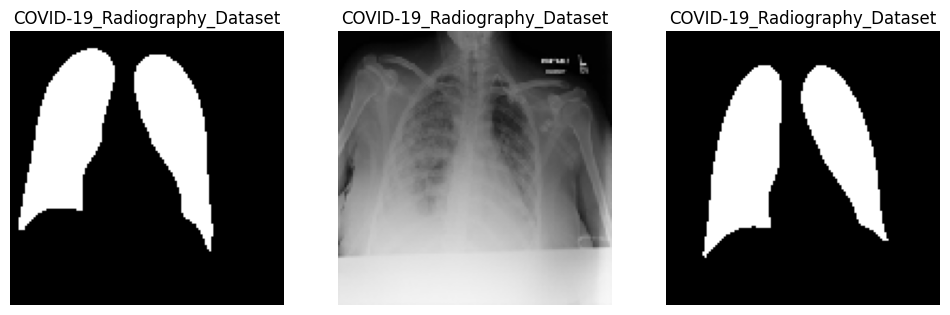

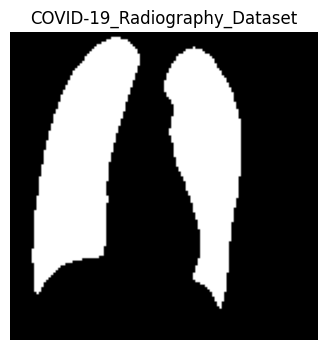

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the path to your dataset (update with your unzipped dataset path)
data_dir = path  # e.g., './COVID-19_Radiography_Dataset'

# Create ImageDataGenerator for loading images (with normalization as per lab)
datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Using 128x128 for faster loading (can use 224x224)
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Get class names
class_names = list(generator.class_indices.keys())
print(f"Classes: {class_names}")

# Function to display images
def display_sample_images(generator, num_images=3):
    # Get one batch of images and labels
    images, labels = next(generator)

    # Plot images
    plt.figure(figsize=(12, 4))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        # Get class name from one-hot encoded label
        class_idx = np.argmax(labels[i])
        plt.title(class_names[class_idx])
        plt.axis('off')
    plt.show()

# Display 3 images
display_sample_images(generator, num_images=3)

# Optionally, display one image per class
def display_one_per_class(generator, class_names):
    # Initialize dictionary to store one image per class
    class_images = {}

    # Keep fetching batches until we have one image per class
    while len(class_images) < len(class_names):
        images, labels = next(generator)
        for img, lbl in zip(images, labels):
            class_idx = np.argmax(lbl)
            if class_idx not in class_images:
                class_images[class_idx] = img

    # Plot one image per class
    plt.figure(figsize=(12, 4))
    for i, (class_idx, img) in enumerate(class_images.items()):
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(class_names[class_idx])
        plt.axis('off')
    plt.show()

# Display one image per class
display_one_per_class(generator, class_names)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths (update with your dataset path after downloading)
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# ImageDataGenerator for loading and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.3  # For step 2
)

# Load images (assuming subdirectories for classes)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize to 224x224
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2  # Placeholder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
from tensorflow.keras import layers, models
# Note: ShuffleNetV2 requires a custom implementation. Using MobileNetV2 as a placeholder.
# Replace with a library like 'efficientnet' or a custom model (e.g., from https://github.com/moskomule/shufflenetv2).
try:
    from efficientnet.tfkeras import ShuffleNetV2  # Example import (may vary)
    base_model_fn = ShuffleNetV2
except ImportError:
    print("ShuffleNetV2 not found. Using MobileNetV2 as a placeholder. Install 'efficientnet' or use a custom model.")
    from tensorflow.keras.applications import MobileNetV2
    base_model_fn = MobileNetV2

# Number of classes
num_classes = len(train_generator.class_indices)

# Load ShuffleNetV2 with ImageNet pre-trained weights (Steps 3 & 4)
# Using scale factor x1.0 as per lab options (x0.5, x1.0, x1.5, x2.0)
base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.0)

# Freeze all base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Replace the last fully connected layers (Step 5)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


# Create the new model
# model = Model(inputs=base_model.input, outputs=predictions)

# Step 6 & 7: Print total parameters and model summary
model.summary()
print(f"Total parameters: {model.count_params()}")

# Step 8: Train the model in three scenarios
# Scenario 1: Last two conv layers + three FC layers
print("\nScenario 1: Training last two conv layers + three FC layers")
for layer in base_model.layers[-2:]:  # Unfreeze last two conv layers
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=0.001),  # As per lab
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
history_1 = model.fit(
    train_generator,
    epochs=20,  # As per lab
    validation_data=val_generator
)

training_time1 = time.time() - start_time
print(f"Training time: {training_time1:.2f} seconds")


ShuffleNetV2 not found. Using MobileNetV2 as a placeholder. Install 'efficientnet' or use a custom model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Total parameters: 4096580

Scenario 1: Training last two conv layers + three FC layers
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 267s 367ms/step - accuracy: 0.6795 - loss: 0.8194 - val_accuracy: 0.8331 - val_loss: 0.4380
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 171s 369ms/step - accuracy: 0.7661 - loss: 0.5822 - val_accuracy: 0.8418 - val_loss: 0.4088
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 168s 363ms/step - accuracy: 0.7869 - loss: 0.5392 - val_accuracy: 0.8677 - val_loss: 0.3530
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 188s 407ms/step - accuracy: 0.7981 - loss: 0.5064 - val_accuracy: 0.8568 - val_loss: 0.3895
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 349ms/step - accuracy: 0.8056 - loss: 0.4845 - val_accuracy: 0.8515 - val_loss: 0.4438
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 166s 358ms/step - accuracy: 0.8106 - loss: 0.4738 - val_accuracy: 0.8608 - val_loss: 0.4311
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 192s 414ms/step - accuracy: 0.8234 - loss: 0.4480 - val_accuracy: 0.8721 - val_lo

In [ ]:
# Evaluate on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)  # Convert predicted probabilities to class indices
y_true = val_generator.classes  # Use labels directly (1D array of class indices)


# Classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

199/199 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step
                 precision    recall  f1-score   support

          COVID       0.84      0.88      0.86      2169
   Lung_Opacity       0.78      0.85      0.82      3607
         Normal       0.91      0.85      0.87      6115
Viral Pneumonia       0.94      0.91      0.93       807

       accuracy                           0.86     12698
      macro avg       0.87      0.87      0.87     12698
   weighted avg       0.86      0.86      0.86     12698



In [ ]:
# Reset for next scenario
for layer in base_model.layers:
    layer.trainable = False

# Scenario 2: Last one conv layer + three FC layers
print("\nScenario 2: Training last one conv layer + three FC layers")
for layer in base_model.layers[-1:]:  # Unfreeze last conv layer
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
start_time = time.time()
history_2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)
training_time2 = time.time() - start_time
print(f"Training time: {training_time2:.2f} seconds")


Scenario 2: Training last one conv layer + three FC layers
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 163s 337ms/step - accuracy: 0.9190 - loss: 0.2094 - val_accuracy: 0.8722 - val_loss: 0.8553
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 156s 336ms/step - accuracy: 0.9251 - loss: 0.1937 - val_accuracy: 0.8721 - val_loss: 0.8517
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 156s 337ms/step - accuracy: 0.9369 - loss: 0.1648 - val_accuracy: 0.8682 - val_loss: 0.8666
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 153s 331ms/step - accuracy: 0.9341 - loss: 0.1697 - val_accuracy: 0.8656 - val_loss: 0.9000
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 155s 334ms/step - accuracy: 0.9458 - loss: 0.1442 - val_accuracy: 0.8593 - val_loss: 1.0697
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 153s 330ms/step - accuracy: 0.9510 - loss: 0.1302 - val_accuracy: 0.8590 - val_loss: 0.9357
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 207s 342ms/step - accuracy: 0.9565 - loss: 0.1178 - val_accuracy: 0.8656 - val_loss: 0.9333
Epoch 8/20
463/4

In [ ]:
# Evaluate on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)  # Convert predicted probabilities to class indices
y_true = val_generator.classes  # Use labels directly (1D array of class indices)


# Classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 293ms/step
                 precision    recall  f1-score   support

          COVID       0.89      0.83      0.86      2169
   Lung_Opacity       0.88      0.77      0.82      3607
         Normal       0.84      0.94      0.89      6115
Viral Pneumonia       0.99      0.80      0.88       807

       accuracy                           0.86     12698
      macro avg       0.90      0.83      0.86     12698
   weighted avg       0.87      0.86      0.86     12698



In [ ]:
# Reset for next scenario
for layer in base_model.layers:
    layer.trainable = False
# Scenario 3: Only the three FC layers
print("\nScenario 3: Training only the three FC layers")
# All conv layers are already frozen
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Measure training time
start_time = time.time()

history_3 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

training_time3 = time.time() - start_time
print(f"Training time: {training_time3:.2f} seconds")


Scenario 3: Training only the three FC layers
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 174s 360ms/step - accuracy: 0.9810 - loss: 0.0539 - val_accuracy: 0.8755 - val_loss: 1.3376
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 159s 344ms/step - accuracy: 0.9835 - loss: 0.0482 - val_accuracy: 0.8723 - val_loss: 1.2669
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 160s 345ms/step - accuracy: 0.9907 - loss: 0.0283 - val_accuracy: 0.8593 - val_loss: 1.4318
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 189s 409ms/step - accuracy: 0.9818 - loss: 0.0538 - val_accuracy: 0.8682 - val_loss: 1.4912
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 160s 345ms/step - accuracy: 0.9915 - loss: 0.0270 - val_accuracy: 0.8745 - val_loss: 1.2966
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 163s 353ms/step - accuracy: 0.9750 - loss: 0.0735 - val_accuracy: 0.8472 - val_loss: 1.4277
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 350ms/step - accuracy: 0.9950 - loss: 0.0179 - val_accuracy: 0.8686 - val_loss: 1.5220
Epoch 8/20
463/463 ━━━━━━━━━━

In [ ]:
# Evaluate on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)  # Convert predicted probabilities to class indices
y_true = val_generator.classes  # Use labels directly (1D array of class indices)


# Classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 304ms/step
                 precision    recall  f1-score   support

          COVID       0.90      0.81      0.85      2169
   Lung_Opacity       0.84      0.83      0.84      3607
         Normal       0.87      0.91      0.89      6115
Viral Pneumonia       0.89      0.92      0.91       807

       accuracy                           0.87     12698
      macro avg       0.88      0.87      0.87     12698
   weighted avg       0.87      0.87      0.87     12698




Evaluation for Scenario 1


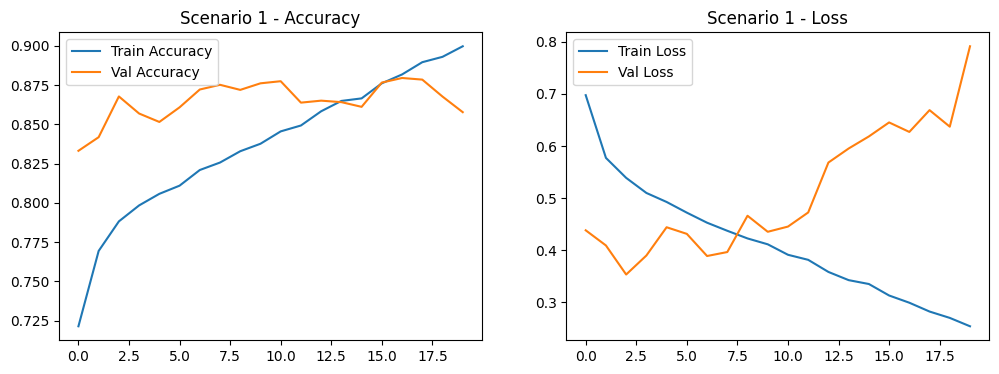


Evaluation for Scenario 2


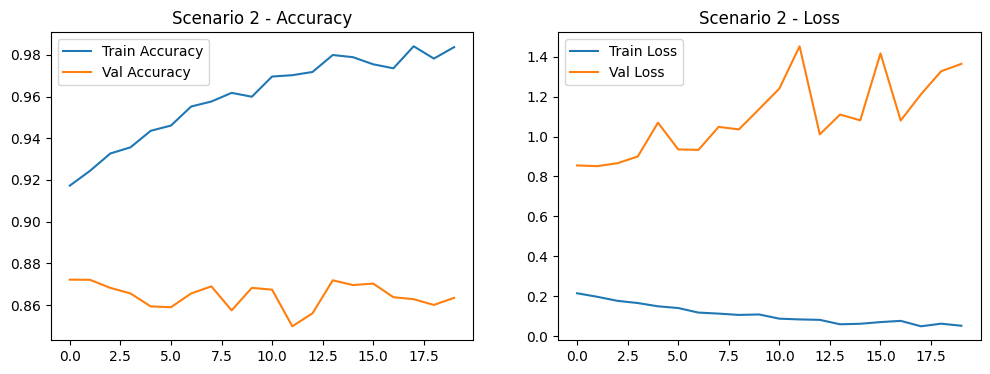


Evaluation for Scenario 3


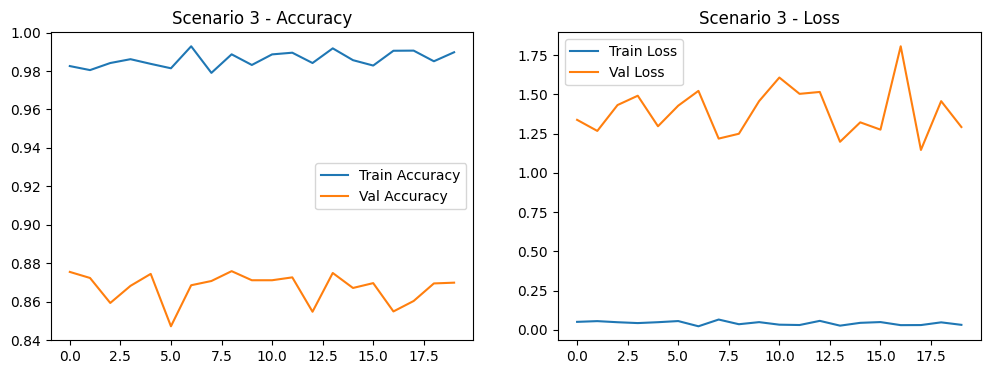

In [ ]:
# Step 9: Evaluate each scenario and plot results
for i, (history, scenario) in enumerate([(history_1, "Scenario 1"),(history_2, "Scenario 2"),(history_3, "Scenario 3")], 1):
    print(f"\nEvaluation for {scenario}")

    # Plot convergence curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{scenario} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{scenario} - Loss')
    plt.legend()
    plt.show()


=== Question 9: Evaluate and Compare Results ===

Evaluating configuration: Scenario 1

Evaluating configuration: Scenario 2

Evaluating configuration: Scenario 3

Training Convergence Curves:


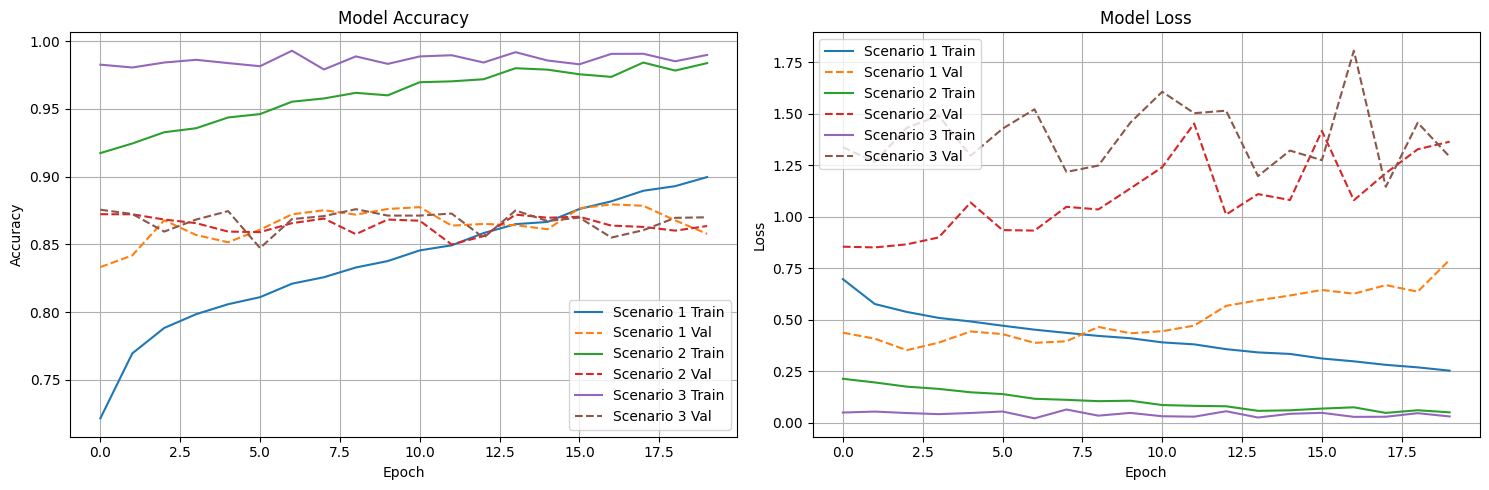

In [ ]:
# -----------------------------------
# 9. Evaluate and Compare Results
# -----------------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print("\n=== Question 9: Evaluate and Compare Results ===")

def plot_convergence(history_dict):
    """Plot training and validation accuracy/loss curves"""
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for config_name, history in history_dict.items():
        plt.plot(history.history['accuracy'], label=f"{config_name} Train")
        plt.plot(history.history['val_accuracy'], '--', label=f"{config_name} Val")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    for config_name, history in history_dict.items():
        plt.plot(history.history['loss'], label=f"{config_name} Train")
        plt.plot(history.history['val_loss'], '--', label=f"{config_name} Val")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Initialize results dictionary
results = {}
history_dict = {
    "Scenario 1": history_1,
    "Scenario 2": history_2,
    "Scenario 3": history_3
}
training_times = {
    "Scenario 1": training_time1,
    "Scenario 2": training_time2,
    "Scenario 3": training_time3
}

# Evaluate each configuration
for config_name in ["Scenario 1", "Scenario 2", "Scenario 3"]:
    print(f"\nEvaluating configuration: {config_name}")

    # Store results
    results[config_name] = {
        'Training Time (s)': training_times[config_name]
    }


# Plot convergence curves
print("\nTraining Convergence Curves:")
plot_convergence(history_dict)

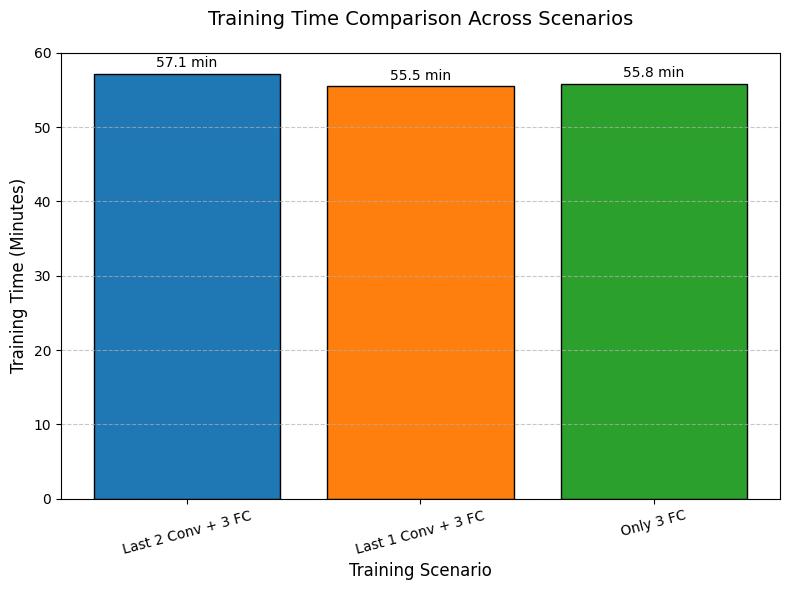

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example training times (in seconds) - replace with your actual values
training_1 = training_time1  
training_2 = training_time2  
training_3 = training_time3  

# Labels for the scenarios
scenarios = ['Last 2 Conv + 3 FC', 'Last 1 Conv + 3 FC', 'Only 3 FC']

# Training times list
training_times = [training_1, training_2, training_3]

# Convert times to minutes for better readability
training_times_minutes = [t / 60 for t in training_times]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(scenarios, training_times_minutes, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f} min', ha='center', va='bottom')

# Customize the plot
plt.title('Training Time Comparison Across Scenarios', fontsize=14, pad=20)
plt.xlabel('Training Scenario', fontsize=12)
plt.ylabel('Training Time (Minutes)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

Part 2 : **Segmentation**

In [5]:
!ls '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define paths (adjust according to your dataset location in Colab)
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load a subset of 500 images and their corresponding masks (balanced across classes)
def load_subset_data_with_masks(data_dir, categories, subset_size=500, img_size=(256, 256)):
    images = []
    masks = []
    labels = []
    target_per_class = subset_size // len(categories)  # 125 images per class

    for category in categories:
        img_path = os.path.join(data_dir, category, 'images')
        mask_path = os.path.join(data_dir, category, 'masks')  # Adjust if your mask directory differs
        count = 0
        for img_name in os.listdir(img_path):
            if count >= target_per_class:
                break
            # Load image
            img_full_path = os.path.join(img_path, img_name)
            img = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]

            # Load corresponding mask
            mask_full_path = os.path.join(mask_path, img_name)  # Assumes mask has the same name
            if not os.path.exists(mask_full_path):
                print(f"Mask not found for {img_name}, skipping...")
                continue
            mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = (mask > 0.5).astype(np.float32)  # Ensure binary mask (0 or 1)

            images.append(img)
            masks.append(mask)
            labels.append(category)
            count += 1

    images = np.array(images)
    masks = np.array(masks)
    labels = np.array(labels)
    # Add channel dimension for compatibility with U-Net
    images = np.expand_dims(images, axis=-1)  # Shape: (500, 256, 256, 1)
    masks = np.expand_dims(masks, axis=-1)    # Shape: (500, 256, 256, 1)
    return images, masks, labels

# Load and preprocess data
images, masks, labels = load_subset_data_with_masks(data_dir, categories)

# Split into training and validation sets
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    images, masks, labels, test_size=0.2, random_state=42
)

# Data augmentation
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Create generators for training
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(mask_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(mask_train, batch_size=8, seed=seed)

# Combine generators
def combined_generator(image_gen, mask_gen):
    for img, msk in zip(image_gen, mask_gen):
        yield (img, msk)

train_generator = combined_generator(image_generator, mask_generator)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()  # Check the number of parameters (~31M)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Calculate steps per epoch
steps_per_epoch = len(X_train) // 8  # Batch size = 8

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_val, mask_val),
    verbose=1
)

# Save the model
model.save('/content/unet_lung_segmentation.h5')

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.6469 - loss: 0.6223 - val_accuracy: 0.7711 - val_loss: 0.4123
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 512ms/step - accuracy: 0.7571 - loss: 0.4203 - val_accuracy: 0.7711 - val_loss: 0.3413
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 527ms/step - accuracy: 0.8094 - loss: 0.3515 - val_accuracy: 0.8925 - val_loss: 0.2610
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 511ms/step - accuracy: 0.8970 - loss: 0.2483 - val_accuracy: 0.9373 - val_loss: 0.1609
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.9182 - loss: 0.1904 - val_accuracy: 0.9484 - val_loss: 0.1344
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.9351 - loss: 0.1496 - val_accuracy: 0.9489 - val_loss: 0.1346
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 515ms/step - accuracy: 0.9311 - loss: 0.1578 - val_accuracy: 0.9544 - val_loss: 0.1150
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.9408 - loss: 0.1314 - val_accura

In [9]:
from tensorflow.keras.metrics import MeanIoU

# Define Dice Coefficient and IoU
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true_f = tf.cast(y_true > threshold, tf.float32)
    y_pred_f = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

def iou(y_true, y_pred, threshold=0.5):
    y_true_f = tf.cast(y_true > threshold, tf.float32)
    y_pred_f = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1.) / (union + 1.)

# Evaluate the model
predictions = model.predict(X_val, batch_size=8)

# Compute metrics
dice = dice_coefficient(mask_val, predictions)
iou_score = iou(mask_val, predictions)
pixel_accuracy = np.mean((predictions > 0.5) == (mask_val > 0.5))

print(f"Dice Coefficient: {dice:.2f}")
print(f"IoU: {iou_score:.2f}")
print(f"Pixel-wise Accuracy: {pixel_accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step
Dice Coefficient: 0.95
IoU: 0.90
Pixel-wise Accuracy: 0.98


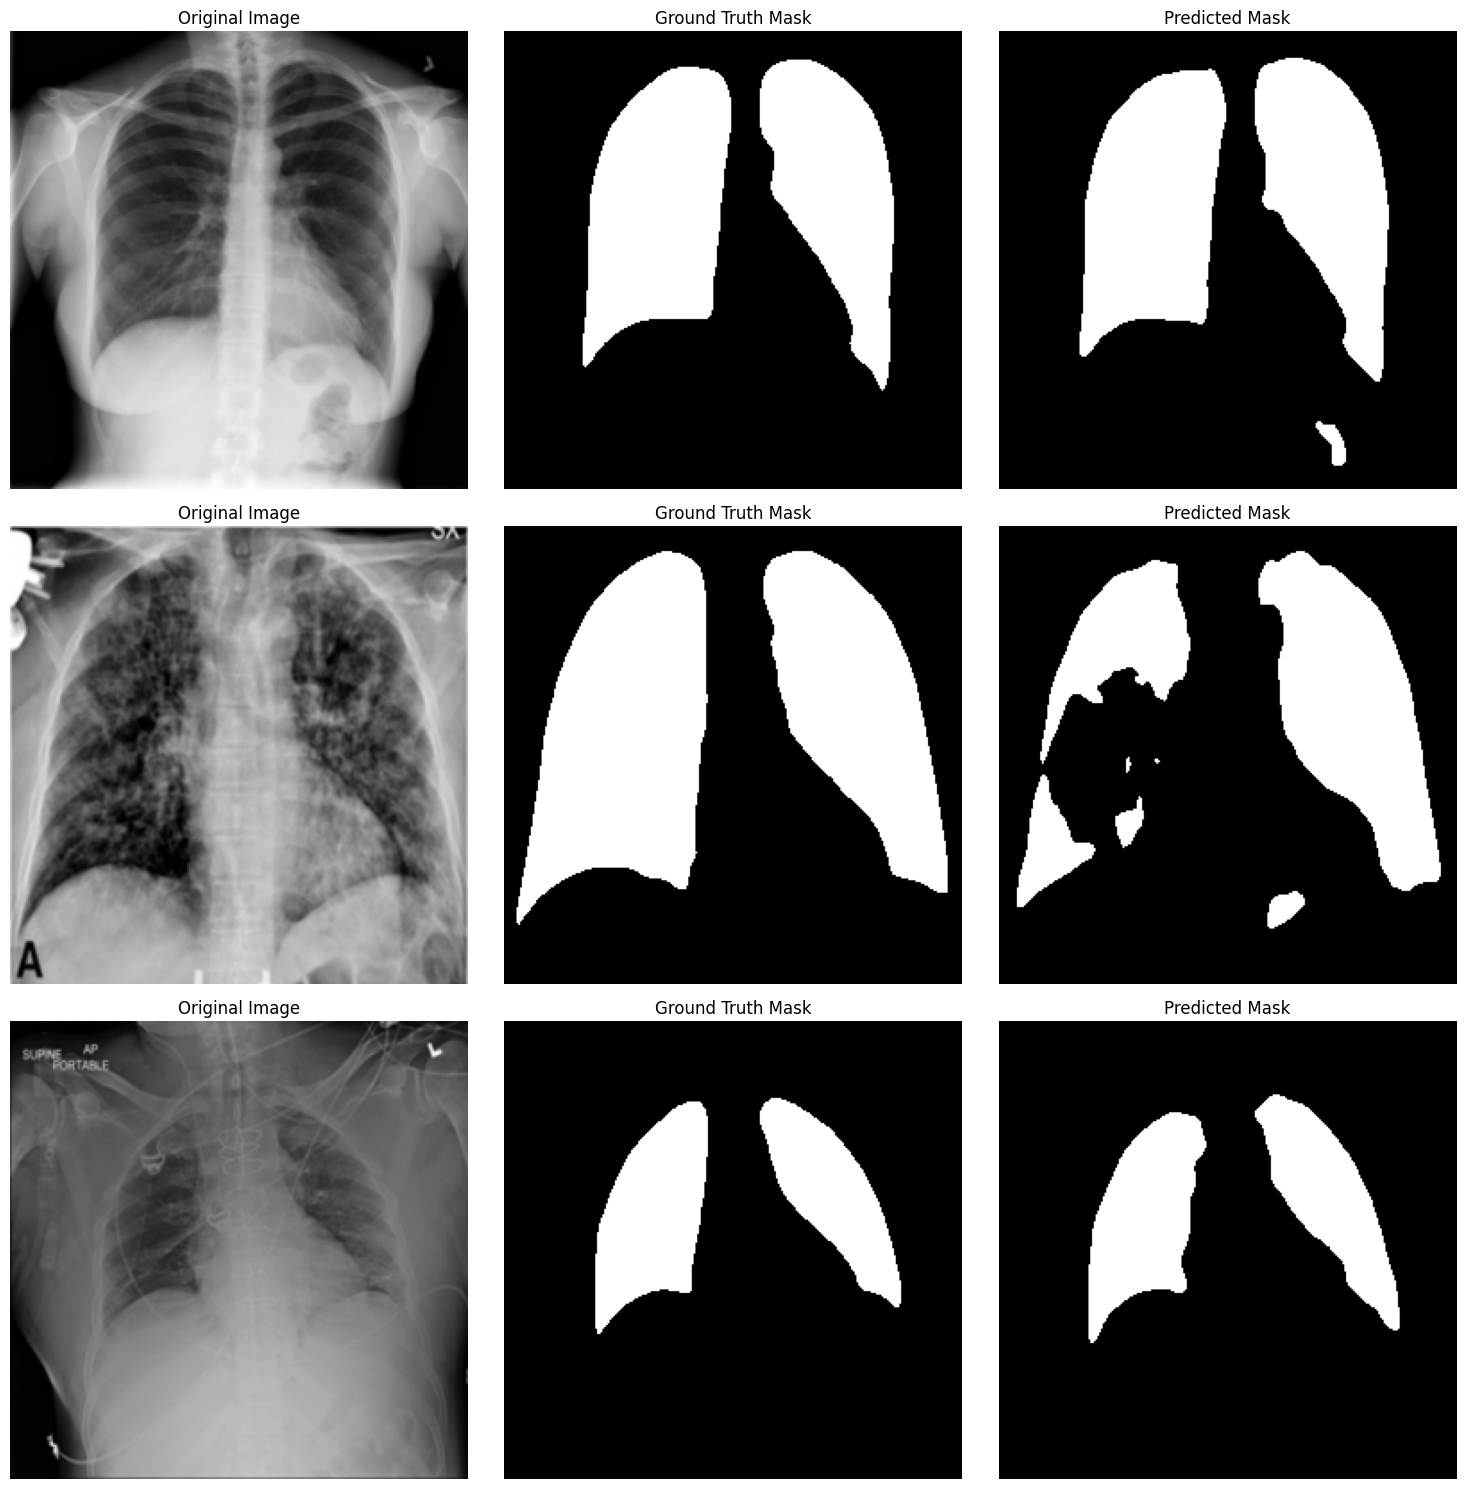

In [10]:
# Visualize predictions
def plot_segmentation_results(images, true_masks, pred_masks, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_masks[i].squeeze() > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/segmentation_masks.png')  # Save for LaTeX report
    plt.show()

# Plot results for 3 samples
plot_segmentation_results(X_val, mask_val, predictions, num_samples=3)